# Transmission

First, we're importing all the necessesary packages. Secondly, we define functions for reading in the observation and opacity data, rebinning the opacity and calculating the contrast (the model for the "fit"). These are then used in the following.

In [10]:
import astropy.io.fits as fits
import astropy.constants as const
import astropy.units as u
import numpy as np
import fancy_matplotlib as plt
import scipy.interpolate as interp
import logging
import pymc as pm
import json

path = "./exoplanetary_atmospheres_data"

def read_opacity_data(molecule):
    """
    reading the .fits opacity files
    """
    file = f"{path}/{molecule}_opacity.fits"
    block = fits.getdata(file)
    T = block[:,0][1:]
    wl = block[0][1:]
    K = block[1:,1:]

    # making it correspond to the observations
    # going from wavelength in nm to wavelength in microns
    waves = wl / 1000
    # changing K from cm^2/g to m^2/kg
    K = np.array(K) * 1
    # reversing both so that wavelength ascends (for K, we reverse subarrays)
    waves = waves[::-1]
    new_k_array = []
    for k_array in K:
        k_array = k_array[::-1]
        new_k_array.append(k_array)
    K = np.array(new_k_array)

    return (waves,K,T)


def read_txt(file_path, values_array):
    """
    Just a lower level function that we use to read the .txt columns
    """
    with open(file_path, "r") as file:
        rows = file.readlines()

    for row in rows:
        row = row.replace("\n", "")
        values_string = row.split()
        values = [float(value) for value in values_string]
        for i, subarray in enumerate(values_array):
            subarray.append(values[i])

    return values_array

    
def read_observation_data(study):
    """
    reading flux variation over wavelength data that we will fit to
    """
    try:
        if study == "denning":
            file_path = f"{path}/Hubble_Denning.txt"
            values_array = [[], [], []]
        if study == "krenberg":
            file_path = f"{path}/Hubble_Krenberg.txt"
            values_array = [[], []]
    except Exception as e:
        logging.error("Not a valid study name", e)


    values_array = read_txt(file_path=file_path, values_array=values_array)

    # denning data is scaled to % as well
    if study == "denning":
        values_array[1] = np.array(values_array[1]) * 100
        values_array[2] = np.array(values_array[2]) * 100

    # krenberg has no errors so we create the same ones as in the lab plot
    if study == "krenberg":
        krenberg_errors = [4e-3] * len(values_array[0])
        values_array.append(krenberg_errors)

    return values_array[0], values_array[1], values_array[2]


def give_opacity(new_temperature, molecule):
    """
    We need to interpolate our opacity onto the chosen temperature.
    For all 8 temperatures in T_array, K_matrix are the opacity values.
    bounds_error lets us also handle temperature > and < than in the array
    (they are just assigned the max/min T value of K given in fill_value)
    this now finds an array of K values based on a given temperature.

    :param list new_temperature: Desired temperature for K values in Kelvin.
    :param list molecule: either "H2O" or "CO2".
    :return list: list of wavelengths, list of opacities
    """
    waves, K_matrix, T_array = read_opacity_data(molecule=molecule)

    K_array_new = interp.interp1d(
        x = T_array,
        y = K_matrix.T,
        bounds_error=False,
        fill_value=(K_matrix[0], K_matrix[-1])
    )(new_temperature).T

    return waves, K_array_new


def import_lab_constants():
    """
    Reading in the data that was given in the lab (we put it in a .json)
    """
    file_name = "transmission_lab_values.json"
    with open(f"{path}/{file_name}") as file:
        lab_dict = json.load(file)
    return lab_dict


def calculate_contrast(k_tot, gamma, R_0, T, mu, g, P_0, R_star):
    """
    The contrast in flux, depending on the current opacity. This is the curve
    that we use to fit the observation values.
    chi_h2O and chi_co2 are the number fractions (fractions of all molecules)
    divided by the total mass of all molecules to our understanding
    kappa_c is the opacity of the rest that is not H2O or CO2
    """

    H = const.k_B * T / (g * mu * const.u)

    radius = (R_0 + H * (gamma + np.log(P_0 * k_tot / g * np.sqrt(2 * np.pi * R_0 / H))))
    
    return ((radius/R_star)**2) * 100

def calculate_contrast2(k_tot, gamma, R_0, T, mu, g, P_0, R_star):
    """
    The contrast in flux, depending on the current opacity. This is the curve
    that we use to fit the observation values.
    chi_h2O and chi_co2 are the number fractions (fractions of all molecules)
    divided by the total mass of all molecules to our understanding
    kappa_c is the opacity of the rest that is not H2O or CO2
    """

    H = const.k_B.si.value * T / (g * mu * const.u.si.value)

    radius = (R_0 + H * (gamma + np.log(P_0 * k_tot / 10 / g * np.sqrt(2 * np.pi * R_0 / H))))
    
    return ((radius/R_star)**2) * 100


def rebin_opacity(opacity, waves_old, waves_target, verbose=False):
    """
    Function used to rebin the opacity data to the observed flux data.
    Just calculates the average per new bin, summing over the former bins and
    dividing by the number of them included. Values in the array are considered
    as starting values for the bin, NOT the center of the bin.

    :return list: list of wavelengths, list of rebinned opacities
    """

    values = np.array(opacity)
    old_bins = np.array(waves_old)
    target_bins = np.array(waves_target)

    new_bin_values = []
    
    for i, curr_target in enumerate(target_bins):

        bin_value = 0

        higher_bound = curr_target
        if i != 0:
            lower_bound = target_bins[i-1]
        else:
            # the first target_bin does not have a start value.
            # This problem is circumvented by assuming it's the same width as
            # the following bin as here
            curr_bin_width = target_bins[i+1] - curr_target
            lower_bound = curr_target - curr_bin_width
        if verbose:
            print("-------------------"
                  + f"bounds: {lower_bound}, {higher_bound}")
        
        # where in the old_bins array we start/stop "integrating"
        upper_ints = np.where(old_bins < lower_bound)
        lower_ints = np.where(old_bins > higher_bound)

        if upper_ints != []:
            int_start = upper_ints[0][-1]
        else:
            logging.warning(f"Old array bins higher overhang is too small, " +
                             "approximating outer bins now.")
            int_start = 0

        if lower_ints != []:
            int_end = lower_ints[0][0]
        else:
            logging.warning(f"Old array bins lower overhang is too small, " +
                             "approximating outer bins now.")
            int_end = len(old_bins) - 1
        
        # cutting the old_bins/values array
        # lower cut
        cut_bins = old_bins[int_start:(int_end+1)]
        cut_values = values[int_start:(int_end+1)]

        # first and last old bin have to be treated differently
        # they might only partially overlap with the new bin
        # their widths
        lower_bin_width = cut_bins[1] - cut_bins[0]
        higher_bin_width = cut_bins[-1] - cut_bins[-2]
        # their overhang percentage
        lower_bin_percentage = (cut_bins[1] - lower_bound) / lower_bin_width
        higher_bin_percentage = (higher_bound - cut_bins[-2]) / higher_bin_width
        # adding them to the bin value
        bin_value += lower_bin_percentage * cut_values[0]
        bin_value += higher_bin_percentage * cut_values[-2]
        if verbose:
            print(f"percentages: {lower_bin_percentage}",
                  + f"{higher_bin_percentage}")

        # for the rest, the "bin percentage" is 1, so:
        for j, _ in enumerate(cut_bins[1:-2]):
            bin_value += cut_values[j]

        # now we need to "normalize" by dividing through the bins used
        bins_used = (len(cut_bins[1:-2]) 
                     + lower_bin_percentage 
                     + higher_bin_percentage)
        bin_value /= bins_used

        new_bin_values.append(bin_value) 

    return np.array(new_bin_values)   

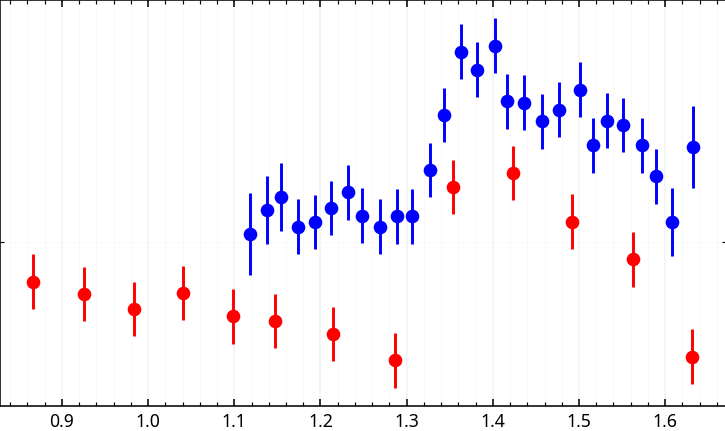

In [12]:
# a general plot of the data :)
fig, ax = plt.subplots()

krenberg_data = read_observation_data(study="krenberg")
denning_data = read_observation_data(study="denning")

ax.errorbar(x=denning_data[0], y=denning_data[1], yerr=denning_data[2],
            color = "b", linestyle="", fmt="o")
ax.errorbar(x=krenberg_data[0], y=krenberg_data[1], yerr=krenberg_data[2],
            color = "r", linestyle="", fmt="o")
plt.show()


In [13]:
# plt.figure(figsize=(20,10))
# plt.pcolormesh(wl[-502000:-500000], T_axis, K_H2O[:,-502000:-500000],
#                  shading= "nearest", cmap = "viridis")
# # plt . pcolormesh ( wl [ -600000: -400000] , T_axis , K_H2O [: , -600000: -400000] , shading = "nearest", cmap = "viridis")
# # plt . pcolormesh ( wl , T_axis , K_H2O , shading = ’ nearest ’ , cmap = ’ viridis ’)
# plt.xlabel(r"Wavelength ($\mu$m)", fontsize =28)
# plt.ylabel("Temperature (K)", fontsize =28)
# plt.title(r"$\kappa_{H_2O}$ over some wavelengths", fontsize=30)
# ax = plt.gca()
# ax.ticklabel_format(useOffset = False)
# for axx in [ax]:
#     axx.xaxis.set_tick_params(labelsize =20)
#     axx.yaxis.set_tick_params(labelsize =20)
#     axx.xaxis.set_minor_locator(AutoMinorLocator(5))
#     axx.tick_params("both", length =10, width =1, which = "major")
#     axx.tick_params("both", length =5, width =1, which = "minor")
# plt.tight_layout()
# plt.savefig("opacities2D.png")

## Rebinning the Opacity

In [14]:
waves_new, k_new, _ = read_opacity_data(molecule="H2O")
waves_new

array([0.80000064, 0.80000128, 0.80000192, ..., 5.49991475, 5.499945  ,
       5.49997525])

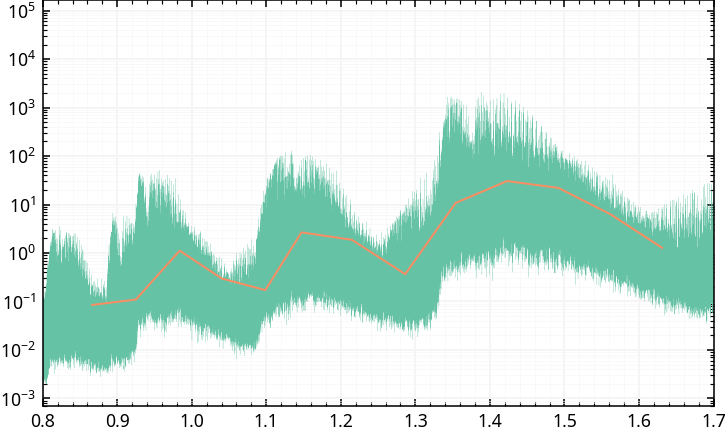

In [16]:
# a general plot of the data :)
fig, ax = plt.subplots()

waves, contrast, contrast_err = read_observation_data(study="krenberg")
waves_k_h2o, k_h2o = give_opacity(new_temperature=300, molecule="H2O")
k_h2o_reb = rebin_opacity(opacity=k_h2o, waves_old=waves_k_h2o,
                          waves_target=waves)
waves_new, k_new, _ = read_opacity_data(molecule="H2O")

ax.plot(waves_new, k_new[0], linewidth=0.1, linestyle="-", marker="")
ax.plot(waves, k_h2o_reb, linewidth=1, linestyle="-", marker="")
ax.set_yscale("log")
ax.set_xlim(0.8,1.7)

plt.show()


## Doing the "Fit"

In [6]:
# dict with all our constants for WASP-12b and the molecular masses
# constants = import_lab_constants()
# wasp = constants["WASP"]
# m_h2o = constants["m_h2o"]
# m_co2 = constants["m_co2"]
# gamma = constants["gamma"]
R_0 = 1.9 * const.R_jup
g = 10 * u.m / u.s**2
R_star = 1.64 * const.R_sun
T = 1200 * u.K
P_0 = 10 * u.bar
mu = 2.33
P = 1.09 * u.d
gamma = 0.57721
m_h2o = (18.02)
m_co2 = (44.01)

# the observation data that we fit to
waves, contrast, contrast_err = read_observation_data(study="krenberg")

# getting h2o opacity comparison values
waves_k_h2o, k_h2o = give_opacity(new_temperature=T.value, molecule="H2O")
# rebinning the opacities to fit the observation data
k_h2o_reb = rebin_opacity(opacity=k_h2o, waves_old=waves_k_h2o,
                          waves_target=waves)

# getting h2o opacity comparison values
waves_k_co2, k_co2 = give_opacity(new_temperature=T.value, molecule="CO2")
# rebinning the opacities to fit the observation data
k_co2_reb = rebin_opacity(opacity=k_co2, waves_old=waves_k_co2,
                          waves_target=waves)

# the parmeters that we "fitted"
chi_h2o = 2e-7  #* u.mol / u.g
chi_co2 = 9.7e-7 #0.6e-10 * u.mol / u.g
kappa_c = 1.35e-5

k_tot = (m_h2o * chi_h2o * k_h2o_reb
         + m_co2 * chi_co2 * k_co2_reb
         + kappa_c) * u.cm**2 / u.g

k_tot_unbinned = (m_h2o * chi_h2o * k_h2o
         + m_co2 * chi_co2 * k_co2
         + kappa_c) * u.cm**2 / u.g

# the values of our fit
model_contrast = calculate_contrast(
    k_tot=k_tot, gamma=gamma, R_0=R_0,
    T=T, mu=mu, g=g, P_0=P_0,
    R_star=R_star)

model_contrast_unbinned = calculate_contrast(
    k_tot=k_tot_unbinned, gamma=gamma, R_0=R_0,
    T=T, mu=mu, g=g, P_0=P_0,
    R_star=R_star)

## Comparing the "Fit" to the Observation

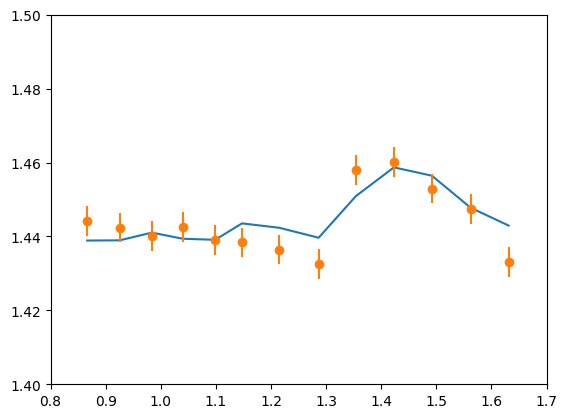

In [7]:
fig, ax = plt.subplots()

#ax.plot(waves_k_h2o, model_contrast_unbinned)
ax.plot(waves, model_contrast)
ax.errorbar(waves, contrast, contrast_err, linestyle="", marker="o")
ax.set_xlim(0.8,1.7)
ax.set_ylim(1.4,1.5)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [chi_h2o, chi_co2, kappa_c]


Output()

Sampling 10 chains for 1_000 tune and 2_000 draw iterations (10_000 + 20_000 draws total) took 98 seconds.


array([<Axes: title={'center': 'chi_h2o'}>,
       <Axes: title={'center': 'chi_co2'}>,
       <Axes: title={'center': 'kappa_c'}>], dtype=object)

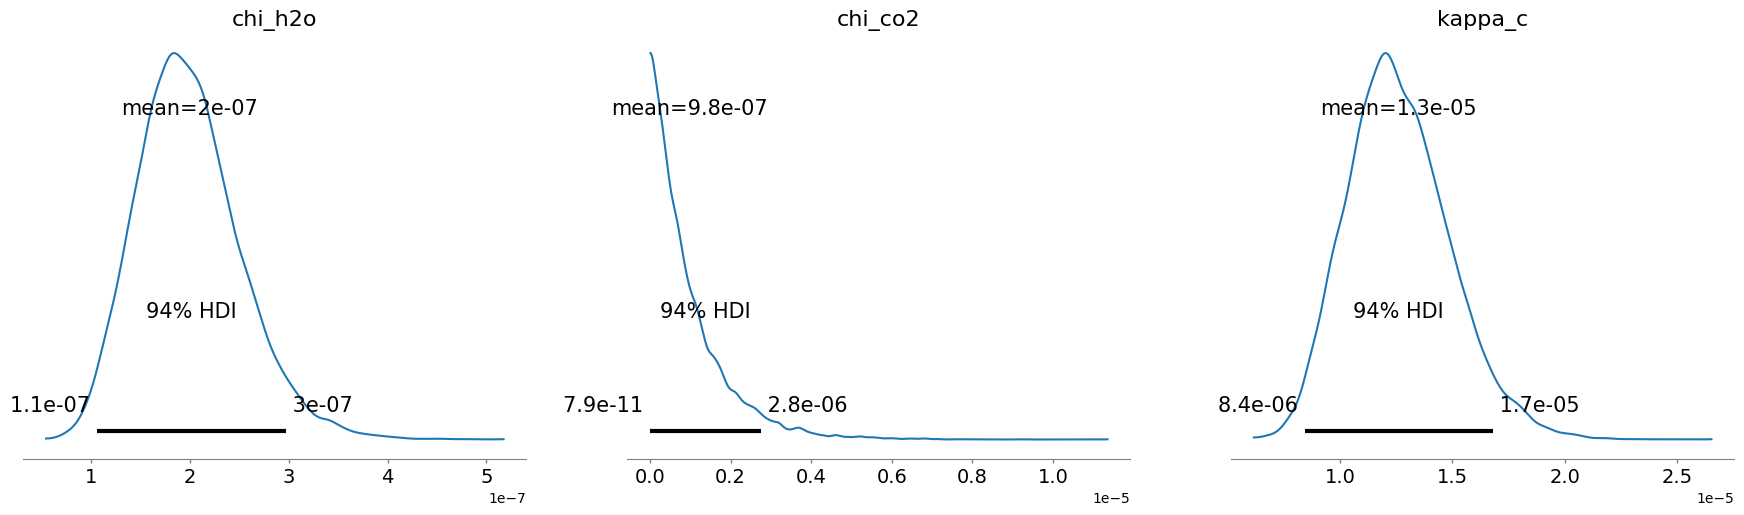

In [8]:
with pm.Model() as model:
    chi_h2o = pm.Uniform("chi_h2o", lower=1e-12, upper=1e12)
    chi_co2 = pm.Uniform("chi_co2", lower=1e-12, upper=1e12)
    kappa_c = pm.Uniform("kappa_c", lower=1e-12, upper=1e12)

    k_tot_model = (m_h2o * chi_h2o * k_h2o_reb
                   + m_co2 * chi_co2 * k_co2_reb
                   + kappa_c)

    model_contrast = calculate_contrast2(
        k_tot=k_tot_model, gamma=gamma, R_0=R_0.value,
        T=T.si.value, mu=mu, g=g.si.value, P_0=P_0.si.value,
        R_star=R_star.si.value)

    # Die Abweichung zwischen dem Modell und den Beobachtungsdaten
    # Hier verwenden wir eine Normalverteilung als Likelihood, da die Fehler normalverteilt sind
    likelihood = pm.Normal("likelihood", mu=model_contrast, sigma=contrast_err, observed=contrast)

    # MCMC Sampler: Verwende NUTS oder eine andere Methode zum Sampling
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, chains=10)

pm.summary(trace)
pm.plot_posterior(trace, var_names=["chi_h2o", "chi_co2", "kappa_c"])


In [9]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chi_h2o,0.0,0.0,0.0,0.0,0.0,0.0,12607.0,10905.0,1.0
chi_co2,0.0,0.0,0.0,0.0,0.0,0.0,10793.0,6917.0,1.0
kappa_c,0.0,0.0,0.0,0.0,0.0,0.0,12935.0,13223.0,1.0
